In [1]:
import numpy as np
import pandas as pd
from pyulgresample.ulogdataframe import DfUlg
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook

import datetime
import sys 
sys.path.append('/home/lucas/Documents/Log_Analysis')
import payload
from analog import avghover as avghover, LogError, ishover as ishover, logextract as logextract


# Hovering Review

rpm plot, avg rpm, thrust plot, avg thrust, current time plot (ready to run)

## Rotating speed

In [2]:
# for logs created by gazebo (simulation)
log_path = '/home/lucas/src/px4/Firmware/build/px4_sitl_default/tmp/rootfs/log'
log_date = '2019-08-14'
log_time = '13_14_23'
log_file = f'{log_path}/{log_date}/{log_time}.ulg'

# for logs imported with QGC
log_path = '/home/lucas/Documents/Log_Analysis/Logs'
log_index = '38'
log_date = '2019-8-27'
log_time = '14-18-14'
log_file = f'{log_path}/log_{log_index}_{log_date}-{log_time}.ulg'
# log_file = f'{log_path}/{log_time}.ulg'
print(log_file)

/home/lucas/Documents/Log_Analysis/Logs/log_38_2019-8-27-14-18-14.ulg


In [3]:
avg_hovering = avghover(log_file)
print(f'Average rotating speed when hovering is {avg_hovering["rpm"]} rpm.')

Average rotating speed when hovering is 1657.8928629557292 rpm.


/home/lucas/Documents/Log_Analysis/analog.py:94: RuntimeWarning: invalid value encountered in less_equal
  elif navstate == 2 and np.all(np.abs([stick_in_x, stick_in_y, stick_in_z]) <= [0.1,0.1,0.1]): # Position control


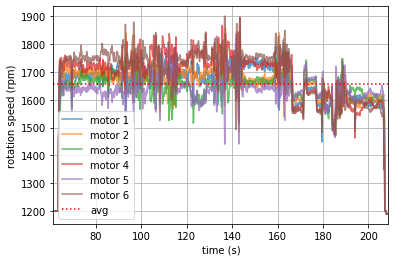

In [4]:
topic_list = ['actuator_outputs','vehicle_local_position_setpoint', 'battery_status']

info = logextract(log_file, topic_list)
time_ao = info['time_ao']
rpm1 = info['rpm'][0]
rpm2 = info['rpm'][1]
rpm3 = info['rpm'][2]
rpm4 = info['rpm'][3]
rpm5 = info['rpm'][4]
rpm6 = info['rpm'][5]


# Figure 1 : Rounds per minutes of the propellers over time
plt.figure()
plt.plot(time_ao,rpm1,label="motor 1",alpha=.7)
plt.plot(time_ao,rpm2,label="motor 2",alpha=.7)
plt.plot(time_ao,rpm3,label="motor 3",alpha=.7)
plt.plot(time_ao,rpm4,label="motor 4",alpha=.7)
plt.plot(time_ao,rpm5,label="motor 5",alpha=.7)
plt.plot(time_ao,rpm6,label="motor 6",alpha=.7)
plt.axhline(avg_hovering['rpm'], label="avg",color='r', linestyle=':')
plt.axis([time_ao[0], time_ao[-1], None, None])
plt.xlabel('time (s)')
plt.ylabel('rotation speed (rpm)')
plt.grid()
plt.legend()
plt.show()

## Thrust

In [5]:
print(f'Average vertical thrust when hovering is {avg_hovering["zthrust"]}.')

Average vertical thrust when hovering is -0.6450544595718384.


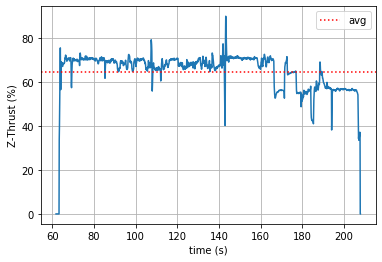

In [6]:
time_vlps = info['time_vlps']
vert_thrust = - info['vert_thrust']*100
# Figure 2 : Vertical thrust over time
plt.figure()
plt.plot(time_vlps, vert_thrust)
plt.axhline(avg_hovering['zthrust']*-100, label="avg",color='r', linestyle=':')
plt.xlabel('time (s)')
plt.ylabel('Z-Thrust (%)')
plt.grid()
plt.legend()
plt.show()


## Current

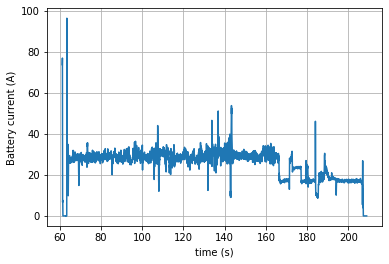

In [7]:
time_bs = info['time_bs']
battery_current = info['battery_current']

# Figure 3 : Battery current over time
plt.figure()
plt.plot(time_bs, battery_current)
plt.xlabel('time (s)')
plt.ylabel('Battery current (A)')
plt.grid()
plt.show()

# Hovering Statistics

## Rotation speed

In [8]:
path2csv = 'avg_hover.csv'

try:
    csv_file = open(path2csv)
except IOError: 
    print(f'The file {path2csv} does not exist or is not readable. Please verify the path.')

In [9]:
paydet = payload.Payload_detecter
print(log_path)
paydet.create_database(log_path)

/home/lucas/Documents/Log_Analysis/Logs


TypeError: create_database() missing 1 required positional argument: 'folder'

In [ ]:
import csv 

reader = csv.DictReader(csv_file)

In [ ]:
rpm = []
thrust = []
for line in reader:
    rpm.append(float(line['Avg rpm']))
    thrust.append(-100*float(line['Avg vert thrust']))

In [ ]:
rpm_bins = range(1190,1900,10)

for k in sorted(range(0,len(rpm_bins))):
    if avg_hovering["rpm"] < rpm_bins[k+1]:
        print(k)
        bin_index = k
        break

In [ ]:
#define RPMMAX 1900 ~30Hz
#define RPMMIN 1200 ~20Hz

color_list = []
for k in range(len(rpm_bins)):
    if k == bin_index :
        color_list.append('r')
    else :
        color_list.append('None')

plt.figure()
pdrpm = pd.Series(rpm)
hist = pdrpm.plot(kind='hist', bins=rpm_bins,edgecolor='k',title='Average rpm distribution')
plt.grid()
plt.xlabel('Rotation velocity (rpm)')
plt.ylabel('Occurences')
hist.patches[bin_index].set_facecolor('r') # the bin in which the current file average falls is highlighted

## Vertical thrust

In [ ]:
step = 1
thrust_bins = range(35,70,1)

for k in range(len(thrust_bins)):
    if -100*avg_hovering["zthrust"] < thrust_bins[k]+step:
        print(k)
        bin_index = k
        break

In [ ]:
plt.figure()
pdt = pd.Series(thrust)
hist = pdt.plot(kind='hist', bins=thrust_bins,edgecolor='k',title='Average thrust distribution')
plt.xlabel('Vertical thrust (%)')
plt.ylabel('Occurences')
plt.grid()
hist.patches[bin_index].set_facecolor('r') # the bin in which the current file average falls is highlighted

In [ ]:
if -100*avg_hovering["zthrust"] > np.mean(thrust) + np.std(thrust) : 
    print(f'The drone most likely carried a load during log with date: {log_date} time: {log_time}')